In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Data preprocessing and loading
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

In [4]:
data_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Validation', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['Train', 'Validation', 'Test']}

In [5]:
# Load a pre-trained EfficientNet model
model = models.efficientnet_b0()
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(dataloaders['Train'], desc=f'\tEpoch {epoch + 1}: Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloaders['Train'])
    train_losses.append(epoch_loss)
    train_accuracy = (correct_train / total_train) * 100
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['Validation'], desc=f'\tEpoch {epoch + 1}: Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels)
        val_loss /= len(dataloaders['Validation'])
        val_losses.append(val_loss.item())

    val_accuracy = (correct_val / total_val) * 100
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

	Epoch 1: Validation: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Epoch 1/25, Train Loss: 0.4762, Val Loss: 0.1934, Train Acc: 83.91%, Val Acc: 93.00%


	Epoch 2: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


Epoch 2/25, Train Loss: 0.3361, Val Loss: 0.1650, Train Acc: 86.93%, Val Acc: 93.88%


	Epoch 3: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


Epoch 3/25, Train Loss: 0.2656, Val Loss: 0.1360, Train Acc: 89.90%, Val Acc: 95.88%


	Epoch 4: Validation: 100%|██████████| 50/50 [00:03<00:00, 14.35it/s]


Epoch 4/25, Train Loss: 0.2246, Val Loss: 0.0942, Train Acc: 91.67%, Val Acc: 97.00%


	Epoch 5: Validation: 100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


Epoch 5/25, Train Loss: 0.1984, Val Loss: 0.1044, Train Acc: 92.82%, Val Acc: 95.75%


	Epoch 6: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.55it/s]


Epoch 6/25, Train Loss: 0.1813, Val Loss: 0.0832, Train Acc: 93.57%, Val Acc: 96.88%


	Epoch 7: Validation: 100%|██████████| 50/50 [00:03<00:00, 13.90it/s]


Epoch 7/25, Train Loss: 0.1517, Val Loss: 0.0774, Train Acc: 94.51%, Val Acc: 97.62%


	Epoch 8: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.05it/s]


Epoch 8/25, Train Loss: 0.1514, Val Loss: 0.0497, Train Acc: 94.45%, Val Acc: 97.88%


	Epoch 9: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.88it/s]


Epoch 9/25, Train Loss: 0.1343, Val Loss: 0.1451, Train Acc: 95.30%, Val Acc: 95.25%


	Epoch 10: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.78it/s]


Epoch 10/25, Train Loss: 0.1342, Val Loss: 0.0790, Train Acc: 95.51%, Val Acc: 97.75%


	Epoch 11: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.81it/s]


Epoch 11/25, Train Loss: 0.1218, Val Loss: 0.0487, Train Acc: 95.67%, Val Acc: 98.25%


	Epoch 12: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


Epoch 12/25, Train Loss: 0.1218, Val Loss: 0.0399, Train Acc: 95.84%, Val Acc: 98.88%


	Epoch 13: Validation: 100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


Epoch 13/25, Train Loss: 0.1100, Val Loss: 0.0389, Train Acc: 96.19%, Val Acc: 98.50%


	Epoch 14: Validation: 100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


Epoch 14/25, Train Loss: 0.1129, Val Loss: 0.0503, Train Acc: 96.20%, Val Acc: 97.62%


	Epoch 15: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


Epoch 15/25, Train Loss: 0.1082, Val Loss: 0.0555, Train Acc: 96.03%, Val Acc: 98.00%


	Epoch 16: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.49it/s]


Epoch 16/25, Train Loss: 0.1068, Val Loss: 0.0292, Train Acc: 96.12%, Val Acc: 98.75%


	Epoch 17: Validation: 100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


Epoch 17/25, Train Loss: 0.0983, Val Loss: 0.0419, Train Acc: 96.68%, Val Acc: 98.00%


	Epoch 18: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.60it/s]


Epoch 18/25, Train Loss: 0.0965, Val Loss: 0.0414, Train Acc: 96.51%, Val Acc: 98.25%


	Epoch 19: Validation: 100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


Epoch 19/25, Train Loss: 0.0901, Val Loss: 0.0298, Train Acc: 96.76%, Val Acc: 99.00%


	Epoch 20: Validation: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s]


Epoch 20/25, Train Loss: 0.0890, Val Loss: 0.0402, Train Acc: 96.81%, Val Acc: 98.88%


	Epoch 21: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.54it/s]


Epoch 21/25, Train Loss: 0.0852, Val Loss: 0.0375, Train Acc: 96.83%, Val Acc: 98.62%


	Epoch 22: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.41it/s]


Epoch 22/25, Train Loss: 0.0984, Val Loss: 0.0264, Train Acc: 96.71%, Val Acc: 98.75%


	Epoch 23: Validation: 100%|██████████| 50/50 [00:03<00:00, 14.79it/s]


Epoch 23/25, Train Loss: 0.0822, Val Loss: 0.0294, Train Acc: 97.01%, Val Acc: 98.50%


	Epoch 24: Validation: 100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


Epoch 24/25, Train Loss: 0.0797, Val Loss: 0.0354, Train Acc: 97.16%, Val Acc: 98.25%


	Epoch 25: Validation: 100%|██████████| 50/50 [00:03<00:00, 14.46it/s]

Epoch 25/25, Train Loss: 0.0821, Val Loss: 0.0289, Train Acc: 97.13%, Val Acc: 98.62%


In [8]:
# Save the model state dictionary
torch.save(model.state_dict(), 'Model_State.pth')

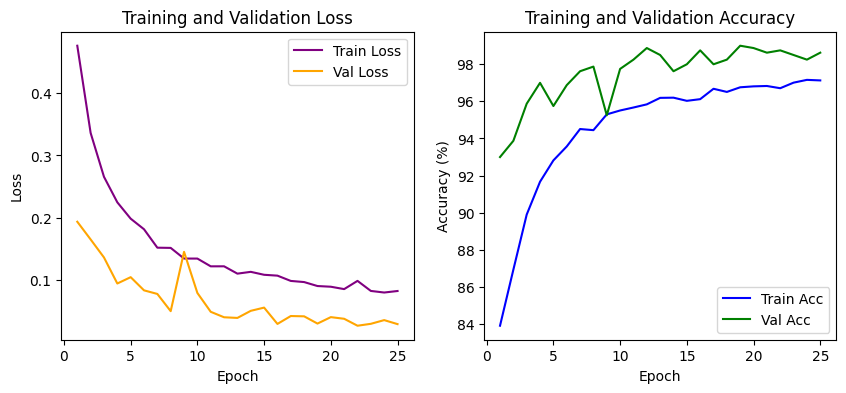

In [9]:
# Evaluation graph of accuracy and loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='purple')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Acc', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Acc', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

100%|██████████| 50/50 [00:03<00:00, 15.21it/s]


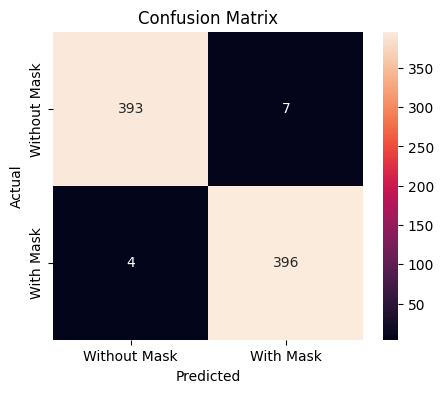

In [10]:
# Confusion Matrix
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['Validation']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=["Without Mask", "With Mask"], yticklabels=["Without Mask", "With Mask"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Testing
model.eval()
sample_images, sample_labels = next(iter(dataloaders['Test']))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

correct = 0
total = 0

with torch.no_grad():
    sample_outputs = model(sample_images)
    _, sample_predictions = torch.max(sample_outputs, 1)
    
    for inputs, labels in tqdm(dataloaders['Test']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Testing Accuracy: {(correct / total) * 100:.2f}%')

100%|██████████| 62/62 [00:10<00:00,  6.11it/s]

Testing Accuracy: 93.15%


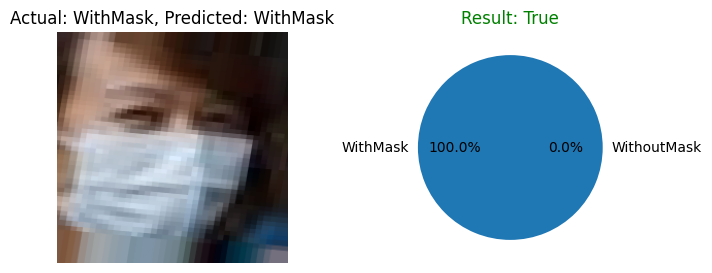

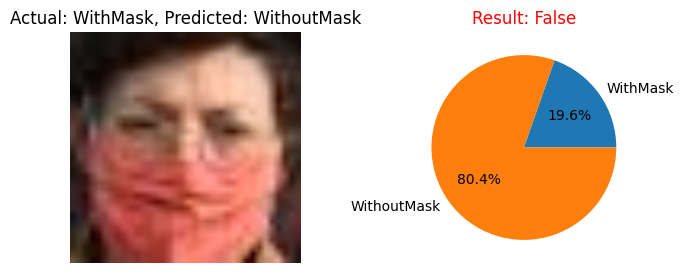

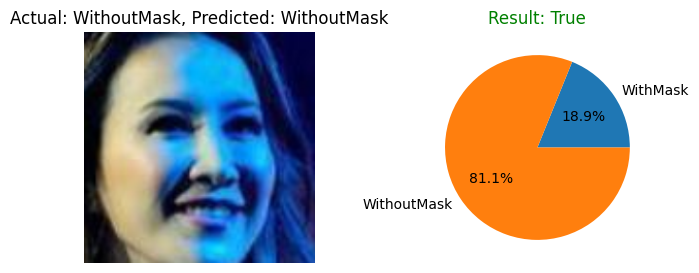

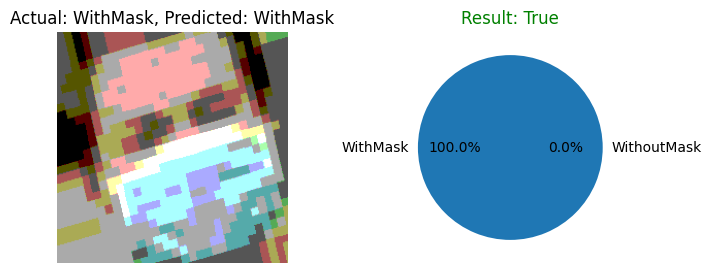

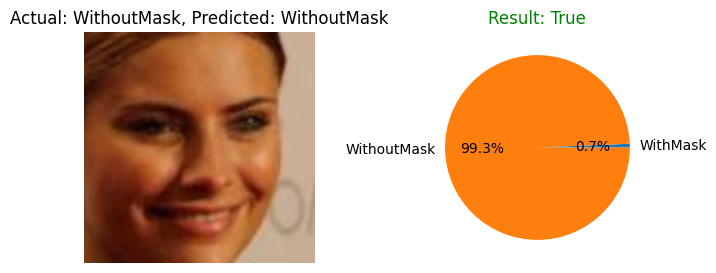

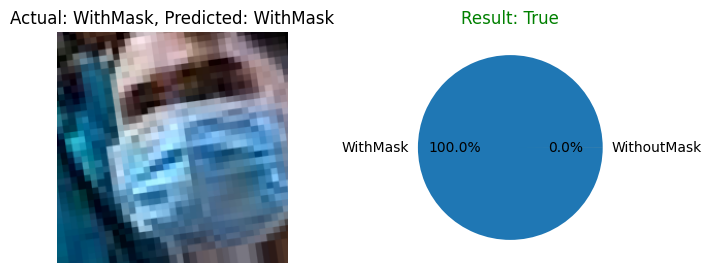

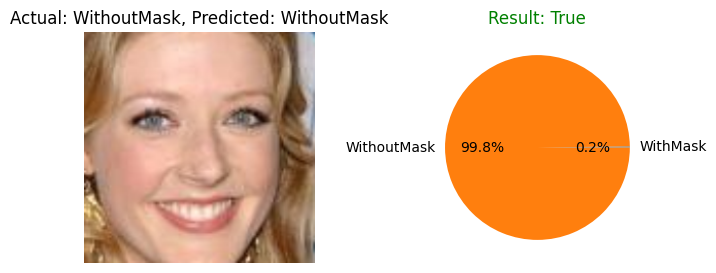

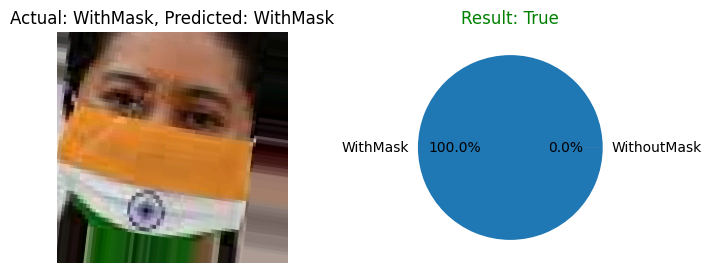

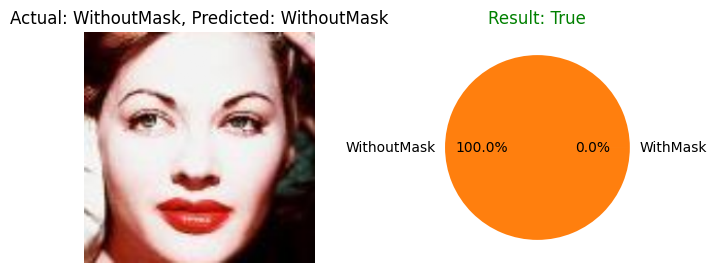

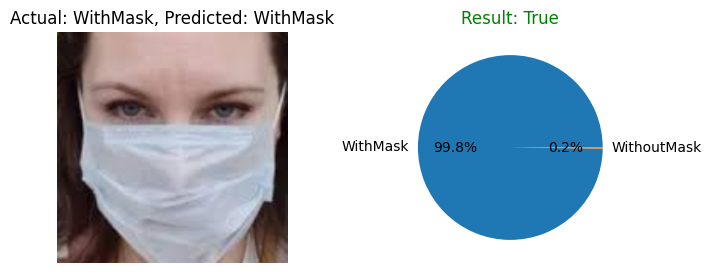

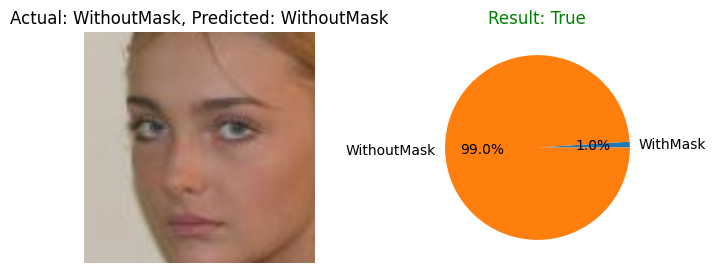

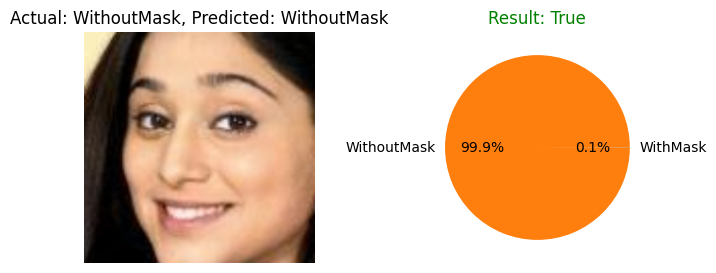

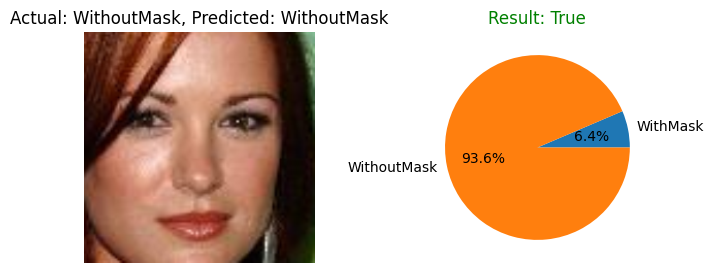

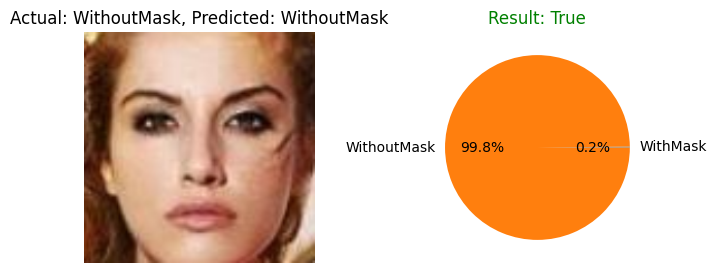

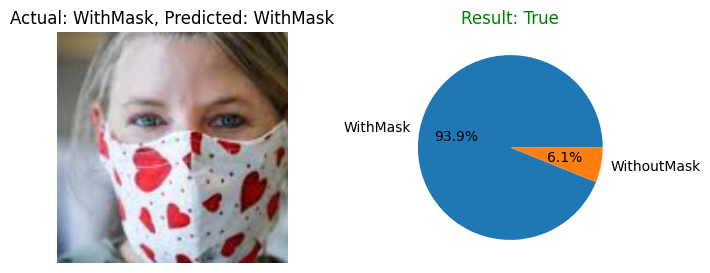

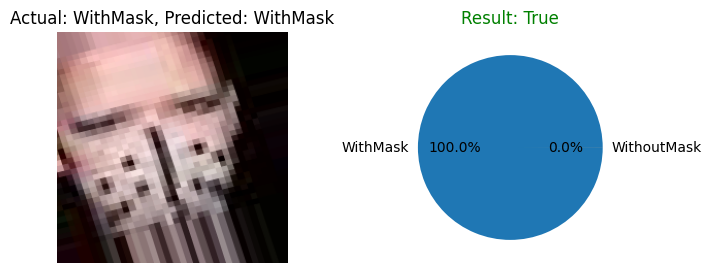

In [12]:
# Sample image prediction
class_names = image_datasets['Validation'].classes

for i in range(len(sample_images)):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    
    true_label = class_names[sample_labels[i]]
    predicted_label = class_names[sample_predictions[i]]
    result_color = 'green' if true_label == predicted_label else 'red'

    plt.title(f'Actual: {true_label}, Predicted: {predicted_label}')
    plt.subplot(1, 2, 2)

    # Extract class probabilities for the current sample
    probabilities = torch.softmax(sample_outputs[i], 0).cpu().numpy()
    class_probabilities = {class_names[j]: probabilities[j] for j in range(len(class_names))}

    # Create a pie chart to visualize class probabilities
    plt.pie(class_probabilities.values(), labels=class_probabilities.keys(), autopct='%1.1f%%')
    plt.title(f'Result: {true_label == predicted_label}', color=result_color)
    plt.show()